In [23]:
# The following is necessary to run the cells that follow. Run this cell once at the beginning, then not again.
%load_ext autoreload
# Changes made to .py files are reflected here
%autoreload 2       
# Reload all modules every time before executing the Python code typed.
import sys         # used for path appending
import matplotlib.pyplot as plt # used for plotting
sys.path.append("../../") # / directory
sys.path.append("../")  # /src/ directory
plt.rcParams["figure.figsize"] = [6, 3.5] #  Size of figures created from plots by default [12,7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A gc_event_dataframe has the following columns
> ## DateTime

> ## TimeFromStart_seconds

> ## EventType

> ## EventName

> ## AdditionalEventInfo

> ## MemoryChange_MB

> ## Duration_miliseconds

In [24]:

                        # Fill in the following 3 variables
################################################################################################
# filespaths = [
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1+max25/gc.log*",
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1/gc.log*",
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log*",
# "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+par/gc.log*" ]
# files = []
# labels = ["jdk11 g1 max 25", "jdk11 g1", "jdk11 cms", "jdk 11 parallel gc"]
filepaths = ["/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+par/gc.log*"]
files= []
labels = ["Sample"]
# time_range_seconds = [0, 100]
time_range_seconds = None  # includes full log
################################################################################################
from src.read_log_file import get_parsed_comparions_from_files, get_file_names_wildcard
for filepath in filepaths:
    files.append(get_file_names_wildcard(filepath))

# Create a list data structure, with each item in the list being a gc_event_dataframe.
gc_event_dataframes = get_parsed_comparions_from_files(files, time_range_seconds,  ignore_crashes=False)


################################## OPTIONAl ############################################

# Import any CSV files that you would like.
csv_files_to_import = ["../../tutorials/tutorial-files/example_data.csv"] # Populate this with CSV files.
csv_file_labels = ["example_data"]
import os.path


################################################################################################

import pandas as pd
for csv_file, label in zip(csv_files_to_import, csv_file_labels):
    if os.path.isfile(csv_file):
        df = pd.read_csv(csv_file)
        gc_event_dataframes.append(df)
        labels.append(label)
    else:
        print("Error: Unable to find file " + csv_file)

In [25]:
print(gc_event_dataframes[0])

                         DateTime TimeFromStart_seconds  EventType EventName  \
0    2021-07-20T12:39:06.466+0000                 1.928  Safepoint      None   
1    2021-07-20T12:39:06.620+0000                 2.083  Safepoint      None   
2    2021-07-20T12:39:06.625+0000                 2.088  Safepoint      None   
3    2021-07-20T12:39:06.662+0000                 2.125  Safepoint      None   
4    2021-07-20T12:39:06.993+0000                 2.455  Safepoint      None   
..                            ...                   ...        ...       ...   
671  2021-07-20T12:47:59.808+0000                535.27  Safepoint      None   
672  2021-07-20T12:48:02.561+0000               538.023      Pause     Young   
673  2021-07-20T12:48:02.561+0000               538.023  Safepoint      None   
674  2021-07-20T12:48:10.343+0000               545.806      Pause     Young   
675  2021-07-20T12:48:10.343+0000               545.806  Safepoint      None   

       AdditionalEventInfo HeapBeforeGC

## Compare STW pauses during runtime

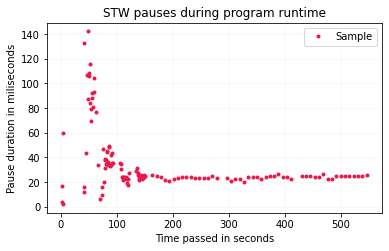

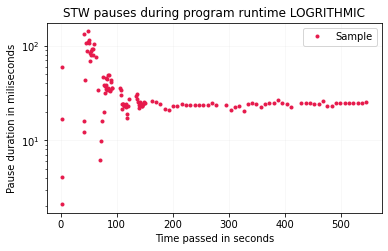

In [26]:
from plotting import plot_scatter

# Chart #1, linear Y axis

# Create a filter that will only take rows from a gc_event_dataframe that represent Pauses.
pauses_only =  [(lambda row : row["EventType"] == "Pause" )]
# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes, 
                    filter_by = pauses_only,
                    labels=labels)
# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
# The alpha value makes the grid harder to see.9
plot.grid(alpha = 0.1)

############################################################################################################
# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)



## Concurrent durations during runtime

       'AdditionalEventInfo', 'HeapBeforeGC', 'HeapAfterGC',
       'Duration_miliseconds'],
      dtype='object')


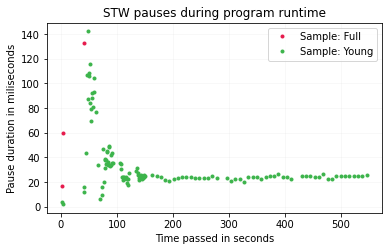

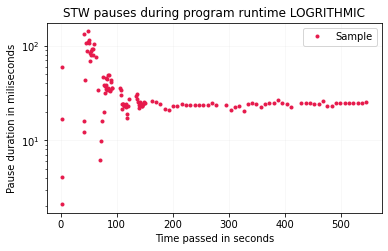

In [27]:
from plotting import plot_scatter

# Chart #1, linear Y axis

# Create a filter that will only take rows from a gc_event_dataframe that represent Pauses.
pauses_only = [(lambda row : row["EventType"] == "Pause")]

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes,
                    filter_by = pauses_only, 
                    labels=labels, 
                    group_by = "EventName")

# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
# The alpha value makes the grid harder to see.9
plot.grid(alpha = 0.1)
############################################################################################################
# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)



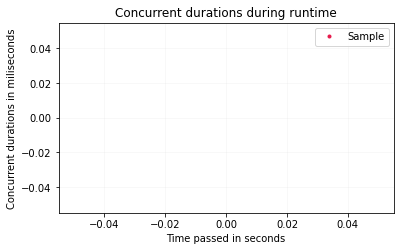

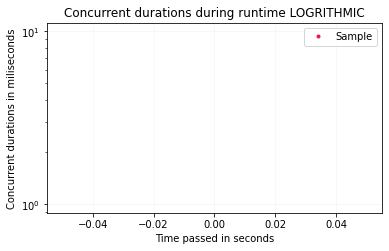

In [28]:
from plotting import plot_scatter

# Linear graph
concurrent_only = [(lambda row: row["EventType"] == "Concurrent")]
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
_ = plot.set_title("Concurrent durations during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)

# Logarithmic graph
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
plot.set_yscale("log")
_ = plot.set_title("Concurrent durations during runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)


## Time spent in STW vs. Concurrent

       'AdditionalEventInfo', 'HeapBeforeGC', 'HeapAfterGC',
       'Duration_miliseconds'],
      dtype='object')


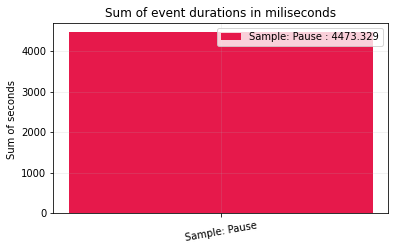

In [29]:
from plotting import plot_bar_sum

log = False # Set to True to view log bar graph as well

duration_present = [(lambda row: row["Duration_miliseconds"] != None)]
# The grouping by eventtype means that every matching event name lives in one group. 
# Example: "Concurrent" events are a group, and "Pause" events are a group
plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
_ = plot.set_title("Sum of event durations in miliseconds")
_ = plot.set_ylabel("Sum of seconds ")
_ = plt.xticks(rotation = 10)
plot.grid(alpha = 0.2)
if log:
    plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
    _ = plot.set_title("Sum of event durations in miliseconds, LOGARITHMIC")
    _ = plot.set_ylabel("Sum of seconds ")
    plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
    plot.grid(alpha = 0.2)
    _ = plt.xticks(rotation = 25)



## Comparing Trends within the data

In [30]:
from plotting import plot_trends

print("\t\t\tPauses during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       filter_by = [lambda row: row["EventType"] == "Pause"],
       labels= labels,
       throughput=True)
print("\n")

print("\t\t\tPauses by name during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= [lambda row: row["EventType"] == "Pause"],
       labels= labels)


			Pauses during runtime
------------------------------------------------------------------------------------------------------------------
  Trends (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      | Throughput    |
-----------------------------------------------------------------------------------------------------------------
Sample          |  126.0000     |  142.3160     | 4473.3290     |   35.5026     |   26.1313     |   99.1800     % 


			Pauses by name during runtime
------------------------------------------------------------------------------------------------------------------
       'AdditionalEventInfo', 'HeapBeforeGC', 'HeapAfterGC',
       'Duration_miliseconds'],
      dtype='object')
  Trends (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      |
-------------------------------------------------------------------------------------------------
Sample: Full    |    3.0000     |  133.0970     |  209.3

## Percentiles of event durations

In [31]:
from plotting import plot_percentiles
print("\t\t\tPauses during runtime\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       filter_by = [lambda row: row["EventType"] == "Pause"],
       labels= labels)

print("\n\n")

print("\t\t\tPauses during runtime by name\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       group_by = "EventName",
       
       filter_by= [lambda row: row["EventType"] == "Pause"],
       labels= labels)

			Pauses during runtime
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | Sample
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 90%       | 95%       | 99%       | 99.9%     | 99.99%    | 
------------------------------------------------------------------------------------------------
A   |   24.7390 |   35.1915 |   79.9320 |  101.5342 |  128.7265 |  141.1636 |  142.2008 | 



			Pauses during runtime by name
----------------------------------------------------------------------------------
       'AdditionalEventInfo', 'HeapBeforeGC', 'HeapAfterGC',
       'Duration_miliseconds'],
      dtype='object')
Legend (All timing in miliseconds) : 
A | Sample: Full
B | Sample: Young
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 90%       | 95%       | 99%    

## Mean durations in miliseconds, pauses

       'AdditionalEventInfo', 'HeapBeforeGC', 'HeapAfterGC',
       'Duration_miliseconds'],
      dtype='object')


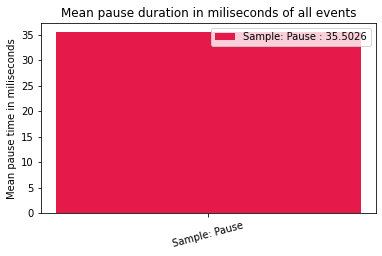

In [32]:

from plotting import plot_bar_avg
graph = plot_bar_avg(gc_event_dataframes, group_by = "EventType", filter_by = [lambda row: row["EventType"] == "Pause"], labels = labels)
_ = graph.set_title("Mean pause duration in miliseconds of all events")
_ = graph.set_ylabel("Mean pause time in miliseconds")
_ = plt.xticks(rotation = 15)

## Heap allocation used before & after GC

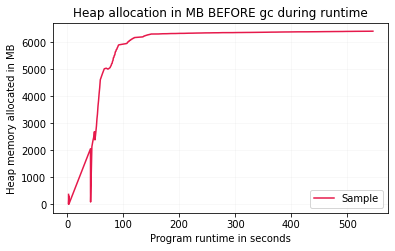

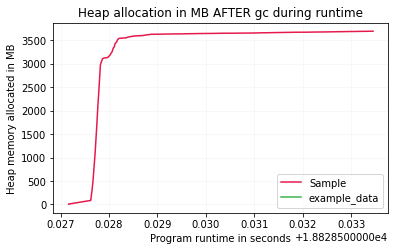

In [33]:
from plotting import plot_line


plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = [lambda row: row["HeapBeforeGC"] != None], # Confirm that this column has data for every row
            labels = labels,
            column = "HeapBeforeGC")

_ = plot.set_title("Heap allocation in MB BEFORE gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = [lambda row: row["HeapAfterGC"]!= None],
            labels = labels,
            column = "HeapAfterGC",
            column_timing="DateTime")

_ = plot.set_title("Heap allocation in MB AFTER gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")

handles, labels = plot.get_legend_handles_labels()
plot.grid(alpha = 0.1)

## MB reclaimed during GC during runtime

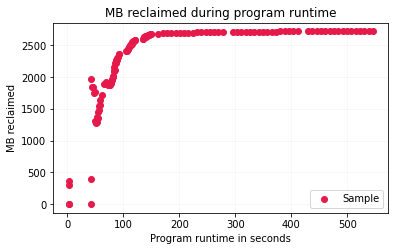

In [34]:
from plotting import plot_reclaimed_bytes

gc_values_present = [lambda row: row["HeapBeforeGC"] != None and row["HeapAfterGC"] != None]

plot = plot_reclaimed_bytes(gc_event_dataframes, filter_by = gc_values_present, labels = labels)
_ = plot.set_title("MB reclaimed during program runtime")
_ = plot.set_ylabel("MB reclaimed")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## Heatmaps for each log

Sample Warning: At least one value lies outside of the provided time range. Max value outside range: 545.806
Sample Warning: At least one value lies outside the provided range for latency. Max value outside range: 142.316


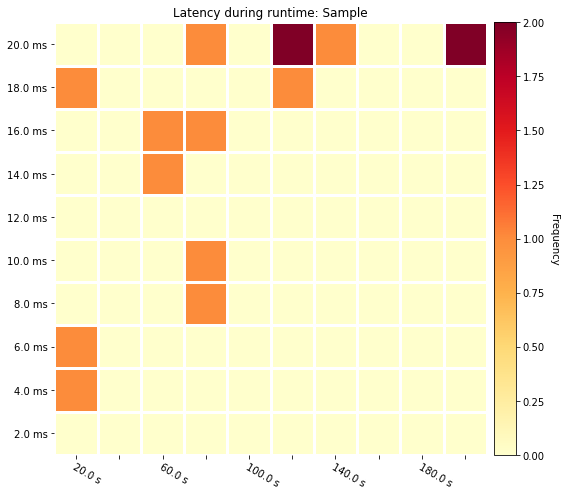

In [41]:
from src.graphing.heatmap import plot_heatmap, get_heatmap_data

for label, gc_event_dataframe in zip(labels, gc_event_dataframes):
    heatmap, dimensions = get_heatmap_data(gc_event_dataframe, 10,10, 20,2, label, True)     # Set the last value to FALSE to get warnings 
    if heatmap.size != 0 and dimensions:
        graph = plot_heatmap(heatmap, dimensions, False) # Set the last value to TRUE to see labels of frequency
        graph.set_title("Latency during runtime: " +  label)
        plt.rcParams["figure.figsize"] = [12, 7]


## Frequency of pauses histogram

Text(0.5, 1.0, 'Pause frequencies during full runtime')

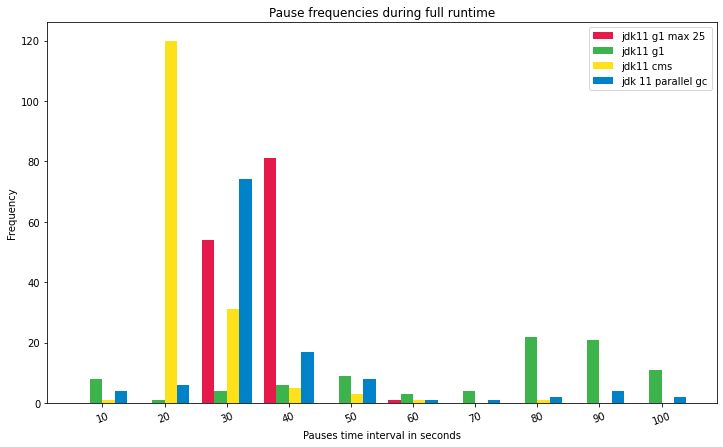

In [ ]:
from plotting2 import plot_frequency_intervals

# All intervals are in seconds
plot = plot_frequency_intervals(gc_event_dataframes,
# /src
                         filter_by = [(lambda row: row["EventType"] == "Pause"), (lambda row: row["Duration_miliseconds"] < 100)], 
                         interval_duration= 10, 
                         labels = labels)
_ = plt.xticks(rotation = 20)
plot.set_xlabel("Pauses time interval in seconds")
plot.set_ylabel("Frequency")
plot.set_title("Pause frequencies during full runtime")


Percentiles plotted:  [99.9, 90, 50]


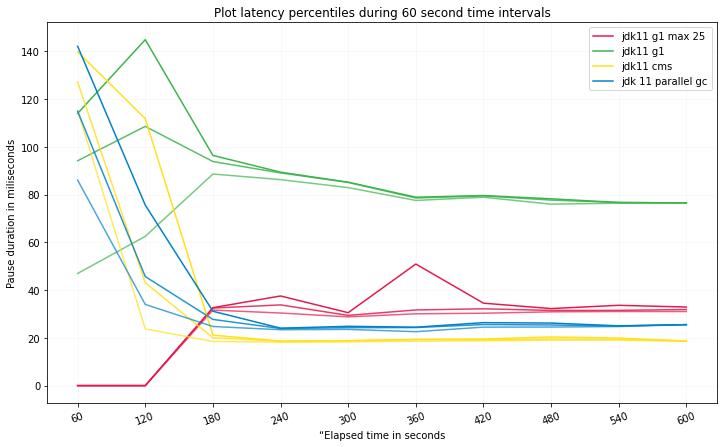

In [ ]:
from plotting2 import plot_percentile_intervals
interval_duration = 60
percentiles = [99.9, 90, 50]
plot = plot_percentile_intervals(gc_event_dataframes, 
                                filter_by = [(lambda row: row["EventType"] == "Pause")], 
                                interval_duration = interval_duration ,
                                labels = labels,
                                percentiles = percentiles )
plot.set_ylabel("Pause duration in miliseconds")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Plot latency percentiles during "+ str(interval_duration) + " second time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)
print("Percentiles plotted: ", percentiles)

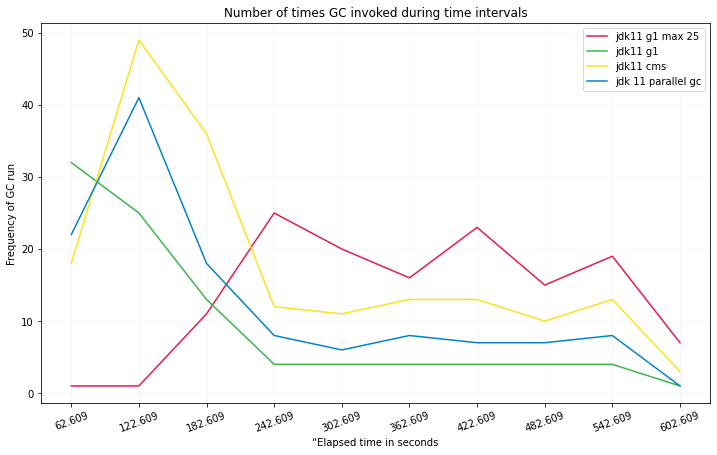

In [ ]:
from plotting2 import plot_frequency_of_gc_intervals

plot = plot_frequency_of_gc_intervals(gc_event_dataframes, 
                                      filter_by = [(lambda row: row["EventType"] == "Pause")], 
                                      interval_duration = 60 , 
                                      labels = labels)
plot.set_ylabel("Frequency of GC run")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Number of times GC invoked during time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

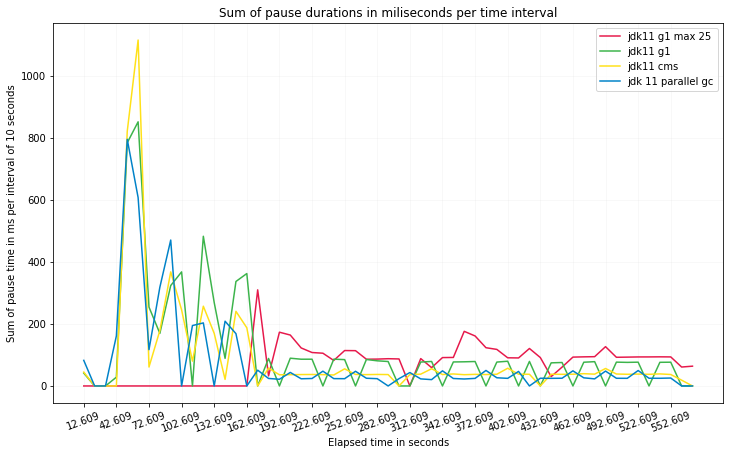

In [ ]:
from plotting2 import plot_sum_pause_intervals


interval_duration = 10
plot = plot_sum_pause_intervals(gc_event_dataframes,
                                filter_by = [(lambda row: row["EventType"] == "Pause")],
                                interval_duration = interval_duration, 
                                labels = labels)
_ = plot.set_title("Sum of pause durations in miliseconds per time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

## Here is an example using external data plotted.

       'AdditionalEventInfo', 'HeapBeforeGC', 'HeapAfterGC',
       'Duration_miliseconds'],
      dtype='object')


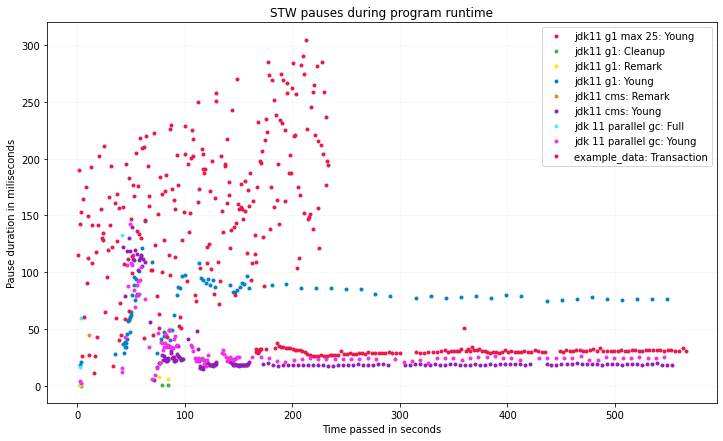

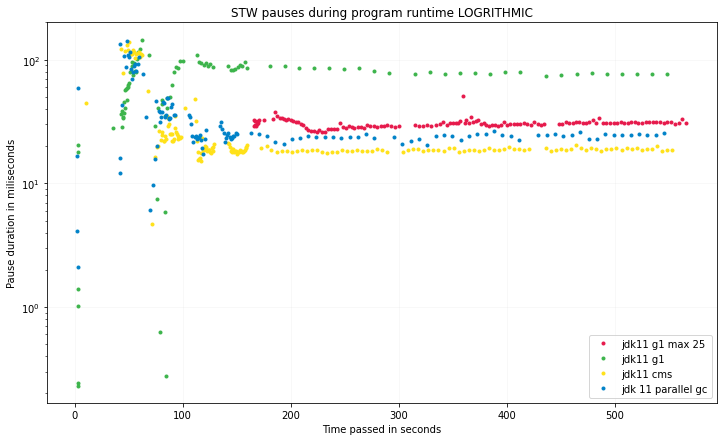

In [ ]:
from plotting import plot_scatter

# Chart #1, linear Y axis

# Create a filter that will only take rows from a gc_event_dataframe that represent Pauses.
pauses_and_transactions = [(lambda row : row["EventType"] == "Pause" or row["EventName"] == "Transaction")]
pauses_only =  [(lambda row : row["EventType"] == "Pause" )]
# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes, 
                    filter_by= pauses_and_transactions,
                    labels=labels,  
                    column= "Duration_miliseconds",
                    group_by = "EventName")
plot = plot_scatter([gc_event_dataframes[-1]], 
                    filter_by= pauses_and_transactions,
                    labels=[labels[-1]],  
                    column= "Duration_miliseconds",
                    column_timing="ExampleName",
                    group_by = "EventName",
                    plot=plot)


# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
# The alpha value makes the grid harder to see.9
plot.grid(alpha = 0.1)
############################################################################################################
# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

